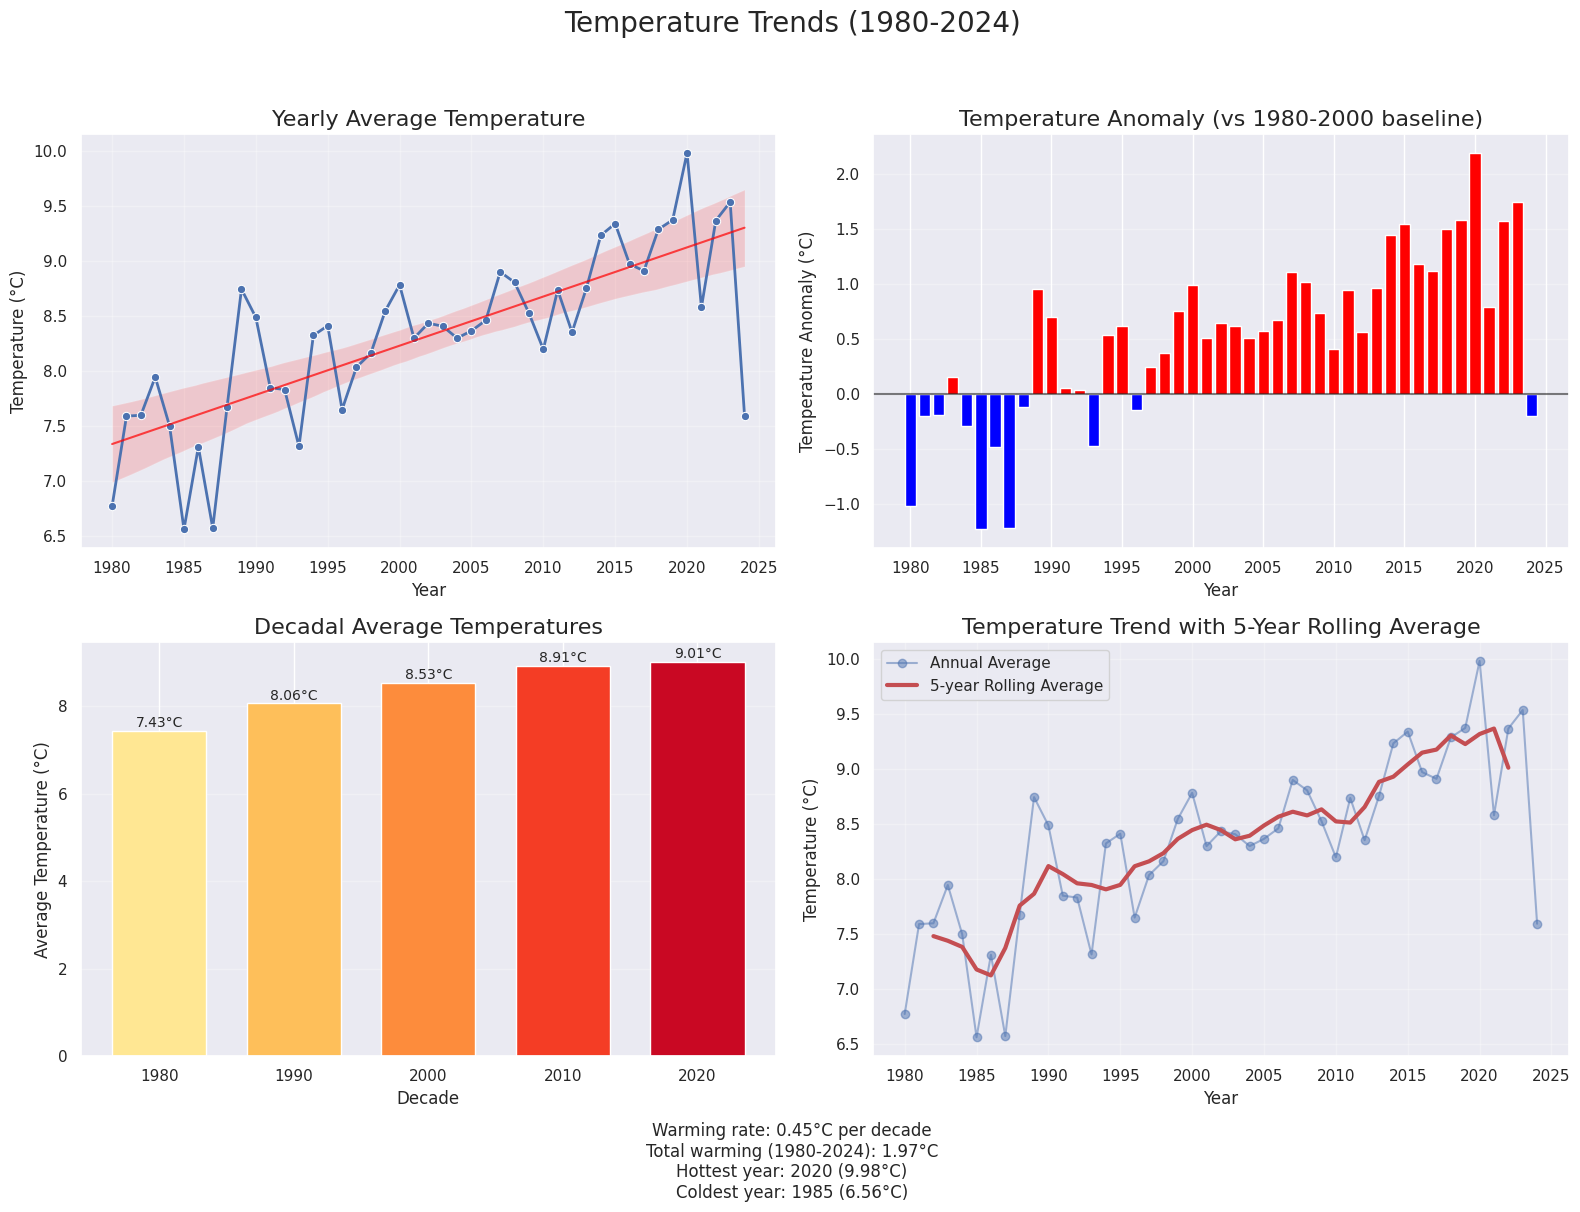

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.ticker import MaxNLocator

# Set style for better looking plots
plt.style.use('ggplot')
sns.set_theme()

# Define file paths for all three periods
output_dir = "/home/ubuntu/DataEngineering/project/results"
input_files = [
    os.path.join(output_dir, "tg_ens_mean_0.25deg_reg_1980-1994_v30.0e_yearly_avg.csv"),
    os.path.join(output_dir, "tg_ens_mean_0.25deg_reg_1995-2010_v30.0e_yearly_avg.csv"),
    os.path.join(output_dir, "tg_ens_mean_0.25deg_reg_2011-2024_v30.0e_yearly_avg.csv")
]

# Combine all data into a single DataFrame
combined_df = pd.DataFrame()
for file in input_files:
    try:
        df = pd.read_csv(file)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Sort by year for proper timeline display
combined_df = combined_df.sort_values('year')

# Calculate reference period average (e.g., 1980-2000)
reference_period = combined_df[(combined_df['year'] >= 1980) & (combined_df['year'] <= 2000)]
baseline_temp = reference_period['yearly_avg_temperature'].mean()

# Calculate anomalies relative to the reference period
combined_df['temperature_anomaly'] = combined_df['yearly_avg_temperature'] - baseline_temp

# Calculate decade averages
combined_df['decade'] = (combined_df['year'] // 10) * 10
decade_avg = combined_df.groupby('decade')['yearly_avg_temperature'].mean().reset_index()

# Create comprehensive visualization
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temperature Trends (1980-2024)', fontsize=20, y=0.98)

# 1. Line plot of yearly temperatures with trend line
sns.lineplot(data=combined_df, x='year', y='yearly_avg_temperature', ax=axs[0, 0], 
             marker='o', linewidth=2, markersize=6)
sns.regplot(data=combined_df, x='year', y='yearly_avg_temperature', ax=axs[0, 0],
            scatter=False, line_kws={"color": "red", "alpha": 0.7, "lw": 1.5})

axs[0, 0].set_title('Yearly Average Temperature', fontsize=16)
axs[0, 0].set_xlabel('Year', fontsize=12)
axs[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axs[0, 0].grid(True, alpha=0.3)
axs[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# 2. Temperature anomaly with color-coded bars
bars = axs[0, 1].bar(combined_df['year'], combined_df['temperature_anomaly'], 
               color=['red' if x > 0 else 'blue' for x in combined_df['temperature_anomaly']])
axs[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axs[0, 1].set_title('Temperature Anomaly (vs 1980-2000 baseline)', fontsize=16)
axs[0, 1].set_xlabel('Year', fontsize=12)
axs[0, 1].set_ylabel('Temperature Anomaly (°C)', fontsize=12)
axs[0, 1].grid(True, alpha=0.3, axis='y')
axs[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

# 3. Decade averages
axs[1, 0].bar(decade_avg['decade'].astype(str), decade_avg['yearly_avg_temperature'], 
         width=0.7, color=sns.color_palette("YlOrRd", len(decade_avg)))
for i, row in decade_avg.iterrows():
    axs[1, 0].text(i, row['yearly_avg_temperature'] + 0.02, 
              f"{row['yearly_avg_temperature']:.2f}°C", 
              ha='center', va='bottom', fontsize=10)
              
axs[1, 0].set_title('Decadal Average Temperatures', fontsize=16)
axs[1, 0].set_xlabel('Decade', fontsize=12)
axs[1, 0].set_ylabel('Average Temperature (°C)', fontsize=12)
axs[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Rolling average (5-year) to show trends more clearly
combined_df['5yr_rolling_avg'] = combined_df['yearly_avg_temperature'].rolling(window=5, center=True).mean()

axs[1, 1].plot(combined_df['year'], combined_df['yearly_avg_temperature'], 'o-', alpha=0.5, label='Annual Average')
axs[1, 1].plot(combined_df['year'], combined_df['5yr_rolling_avg'], 'r-', linewidth=3, label='5-year Rolling Average')
axs[1, 1].set_title('Temperature Trend with 5-Year Rolling Average', fontsize=16)
axs[1, 1].set_xlabel('Year', fontsize=12)
axs[1, 1].set_ylabel('Temperature (°C)', fontsize=12)
axs[1, 1].grid(True, alpha=0.3)
axs[1, 1].legend()
axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Add summary statistics
trend_coefficient = np.polyfit(combined_df['year'], combined_df['yearly_avg_temperature'], 1)[0]
warming_rate = trend_coefficient * 10  # Warming per decade

stats_text = (
    f"Warming rate: {warming_rate:.2f}°C per decade\n"
    f"Total warming (1980-2024): {trend_coefficient * (2024-1980):.2f}°C\n"
    f"Hottest year: {combined_df.loc[combined_df['yearly_avg_temperature'].idxmax(), 'year']} "
    f"({combined_df['yearly_avg_temperature'].max():.2f}°C)\n"
    f"Coldest year: {combined_df.loc[combined_df['yearly_avg_temperature'].idxmin(), 'year']} "
    f"({combined_df['yearly_avg_temperature'].min():.2f}°C)"
)

# Add text box with statistics
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
fig.text(0.5, 0.02, stats_text, ha='center', va='center', fontsize=12, bbox=props)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save figure
plt.savefig(os.path.join(output_dir, "temperature_trends_1980_2024.png"), dpi=300, bbox_inches='tight')
plt.show()